In [57]:
import numpy as np
from numpy.random import random
from networkx import from_numpy_matrix
import networkx as nx
import matplotlib.pyplot as plt

class Graph:
    def __init__(self, directed=False):
        self._eta = 100
        self._adj = np.zeros(shape=(self._eta, self._eta), dtype=np.int8)
        self._n = 0
        self._directed = directed

    def set_adj(self, adj):
        self._adj = adj
        self._n = adj.shape[0]

    def degrees(self, kind='any'):
        if kind == 'any' or kind == 'in':
            return np.sum(self._adj, axis=0)
        elif kind == 'out':
            return np.sum(self._adj, axis=1)
        else:
            raise ValueError('Error: wrong deg kind: {}'.format(kind))

    def indegrees(self):
        return self.degrees(kind='in')

    def degree_histogram(self, kind='any'):
        degrees = self.degrees(kind)
        return np.histogram(degrees, bins=int(max(degrees)))

    def batch_add_node(self, n):
        for _ in range(n):
            self.add_node()

    def add_node(self):
        self._n += 1
        if self._n >= self._node_count():
            self._expand()
        return self._n - 1

    def add_edge(self, i, j):
        if (i >= self._n) or (j >= self._n) or (i < 0) or (j < 0):
            raise ValueError('Cannot add edge ({}, {})'.format(i, j))
        else:
            self._adj[i, j] = 1
            if not self._directed:
                self._adj[j, i] = 1

    def to_networkx(self):
        sanitized_adj = self._adj[:self._n, :self._n]

        return from_numpy_matrix(sanitized_adj)

    def _node_count(self):
        return self._adj.shape[0]

    def _expand(self):
        self._adj = np.pad(self._adj, ((0, self._eta), (0, self._eta)), mode='constant', constant_values=0)

def plot_networkx(g):
    nodes, degrees = zip(*nx.degree(g))
    nx.draw(g, nodelist=nodes, node_size=[v * 100 for v in degrees])
    plt.show()

def plot_histogram(g):
    hist, bin_edges = g.degree_histogram()
    plt.bar(bin_edges[:-1], hist, width = 1)
    plt.xlim(min(bin_edges), max(bin_edges))
    plt.show() 

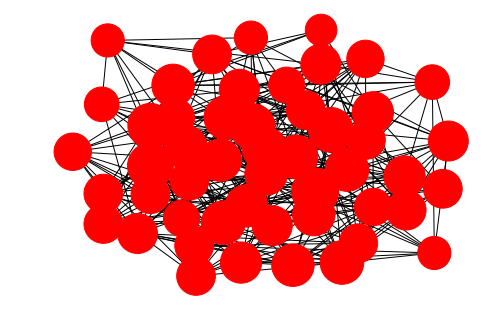

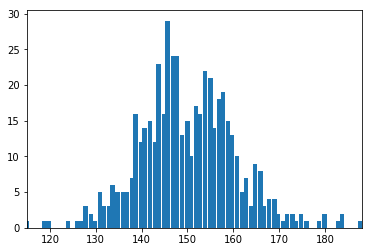

In [58]:
def ErdosRenyi(n, p):
    adj = np.random.random(size=(n, n))
    adj = adj * (1 - np.eye(n))

    lower_triangle_ixs = np.tril_indices(n, -1)
    adj[lower_triangle_ixs] = adj.T[lower_triangle_ixs]

    adj = (adj < p).astype(dtype=np.int8)

    g = Graph(directed=False)
    g.set_adj(adj)
    return g

g = ErdosRenyi(50, 0.3)
plot_networkx(g.to_networkx())

g = ErdosRenyi(500, 0.3)
plot_histogram(g) 

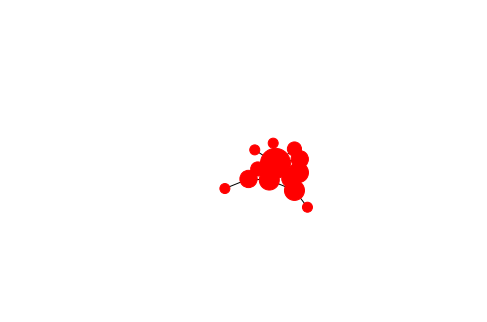

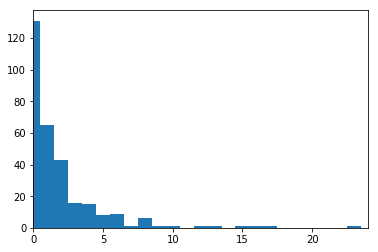

In [59]:
def FullyConnected(n):
    adj = np.ones(n) * (1 - np.eye(n))

    g = Graph(directed=False)
    g.set_adj(adj)
    return g

def AlbertBarabasi(n):
    g = FullyConnected(2)
    first_node_ix = 2

    for node_ix in range(first_node_ix, n):
        indegrees = g.indegrees()
        target_probabilities = indegrees / np.sum(indegrees)

        r = np.random.random(target_probabilities.shape)
        edge_decision = r < target_probabilities

        g.add_node()
        for target, add_flag in enumerate(edge_decision):
            if add_flag:
                g.add_edge(node_ix, target)

    return g

g = AlbertBarabasi(20)
plot_networkx(g.to_networkx())

g = AlbertBarabasi(250)
plot_histogram(g)

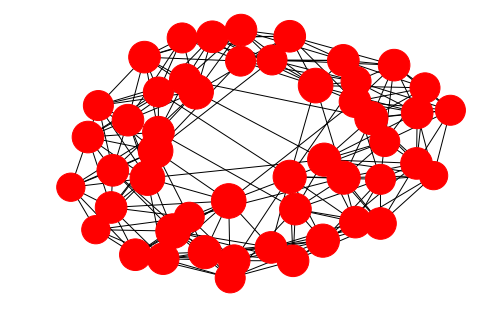

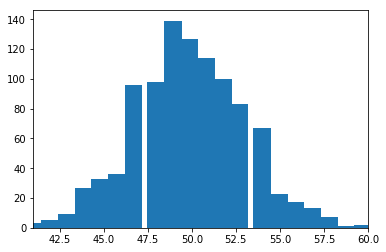

In [70]:
def CircleGraph(n, k):
        adj = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if 0 < abs(i - j) % (n - 1 - (k // 2)) <= k // 2:
                    adj[i, j] = 1
        g = Graph(directed=True)
        g.set_adj(adj)
        return g

def WattsStrogatz(n, k, beta,):
    def rewire(adj, i, j):
        possible_links = [ix for ix in np.where(adj[i,:] == 0)[0] if ix != i]
        link = np.random.choice(possible_links, size=1)

        adj[i,j] = adj[j,i] = 0
        adj[i,link] = adj[link,i] = 1

    g = CircleGraph(n, k)
    adj = g._adj.copy()
    rewire_queue = []
    for i in range(n):
        for j in range(i + 1, n):
            if adj[i, j] == 1:
                if np.random.binomial(1, beta):
                    rewire_queue.append((i, j))

    for i, j in rewire_queue:
        rewire(adj, i, j)

    g.set_adj(adj)
    return g

g = WattsStrogatz(50, 10, 0.1)
plot_networkx(g.to_networkx())

g = WattsStrogatz(1000, 50, 0.2)
plot_histogram(g)